In [1]:
import torch
from torch.autograd import Variable
import torchvision

import numpy as np
import os, time
import easydict

from utilities.init import make_dirs, init_data_loader, write_preprocessor
from utilities.parser import get_default_parser
from architecture.nn import VAE

from matplotlib import pyplot as plt

In [2]:
to_np = lambda x: x.data.cpu().numpy()
normalize_to_zero_one = lambda x: (x + 1.) / 2.
back_norm = lambda x: 2 * x - 1

In [3]:
config = easydict.EasyDict({
    'remove_bg': False,
    'ckpt_path': 'ckpt',
    'dataset': 'ur5',
    'data_path': '../vae/data',
    'batch_size': 4,
    'training_digits': None,
    'img_path': 'out',
    'z_dim': 256,
    'num_filters_in_final_layer': 256,
    'num_conv_layers': 4,
    'num_channels': 3,
    'model': 'vae',
    'std': .02,
})

In [20]:
data_loader, config.img_size, config.num_channels = init_data_loader(
    config.dataset, config.data_path, config.batch_size, \
    training_digits=config.training_digits, remove_background=config.remove_bg)
config.c_dim = [config.num_filters_in_final_layer, config.img_size // 2**config.num_conv_layers, config.img_size // 2**config.num_conv_layers]

In [5]:
vae = VAE(config)
vae = vae.cuda()
vae.load_state_dict(torch.load(os.path.join(config.ckpt_path, 'v.pth')))

<All keys matched successfully>

In [21]:
for step, (images, indices) in enumerate(data_loader, 0):
    images = images.reshape(-1, 3, 96, 96).float() / 255
    x = Variable(images.type(torch.cuda.FloatTensor))
    x = normalize_to_zero_one(x)
    x_r, mu, log_sigma_sq = vae(x)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


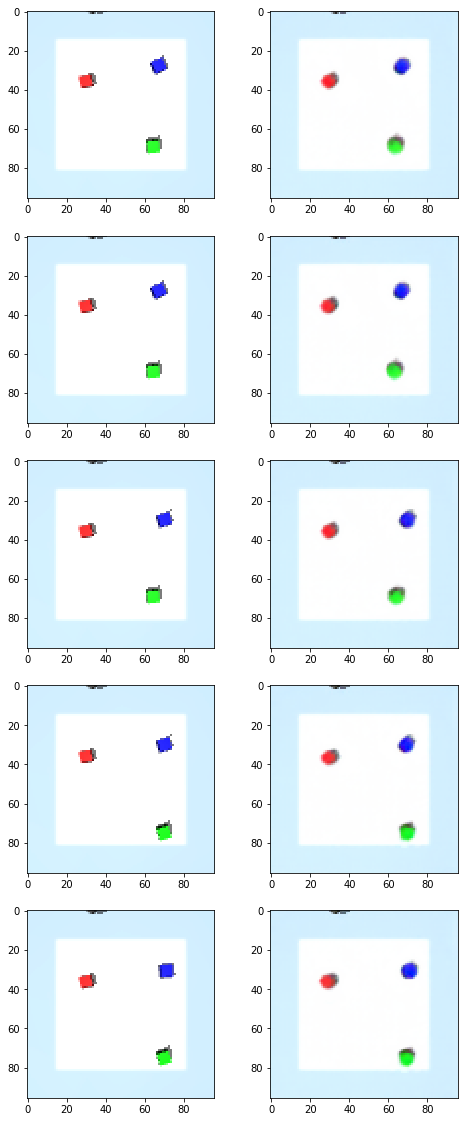

In [22]:
f, ax = plt.subplots(5, 2)
f.set_figwidth(8)
f.set_figheight(20)
ax[1][0].imshow(np.zeros([32,32]))

mu_list = []
for i in range(5):
    im_org = to_np(x[i]).transpose([1,2,0])
    im_org = back_norm(im_org)
    ax[i][0].imshow(im_org)
    
    im_recon = to_np(x_r[i]).transpose([1,2,0])
    im_recon = back_norm(im_recon)
    ax[i][1].imshow(im_recon)
    
    mu_list.append(mu[i])

In [27]:
def get_dist(mu1, mu2):
    return np.linalg.norm((mu1 - mu2).detach().cpu().numpy())

In [29]:
for i in range(len(mu_list)-1):
    print(i, get_dist(mu_list[i], mu_list[i+1]))

0 0.0020515644
1 1.50557
2 1.9269978
3 0.5963923


In [29]:
for i in range(len(mu_list)-1):
    print(i, get_dist(mu_list[i], mu_list[i+1]))

0 0.0020515644
1 1.50557
2 1.9269978
3 0.5963923


In [57]:
f.savefig('test.png')

In [38]:
def plot_tensor(data):
    img = to_np(data[0]).transpose([1,2,0])
    plt.imshow(back_norm(img))
    plt.show()

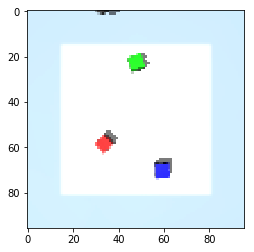

In [40]:
plot_tensor(x)

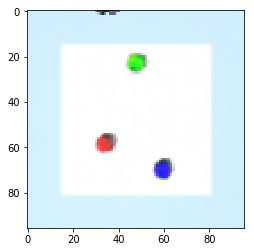

In [39]:
plot_tensor(x_r)